<a href="https://colab.research.google.com/github/Valent0296/allvent.github.io/blob/master/Human_Activity_Recognition_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Human activity recognition is the problem of classifying sequences of data recorded by specialized harnesses or smart phones into known well-defined Human activities.

It is a challenging problem as the large number of observations are produced each second, the temporal nature of the observations, and the lack of a clear way to relate data to known movements increase the challenges.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/MyDrive/dataset/")
import torch
from torch import Tensor
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
#carico i dati
%cd /content/drive/MyDrive/dataset/
train = pd.read_csv("train-1.csv")
test = pd.read_csv("test.csv")

/content/drive/MyDrive/dataset


{0: 'STANDING', 1: 'SITTING', 2: 'LAYING', 3: 'WALKING', 4: 'WALKING_DOWNSTAIRS', 5: 'WALKING_UPSTAIRS'}
561
Activity
2    1944
0    1906
1    1777
3    1722
5    1544
4    1406
Name: count, dtype: int64


<BarContainer object of 6 artists>

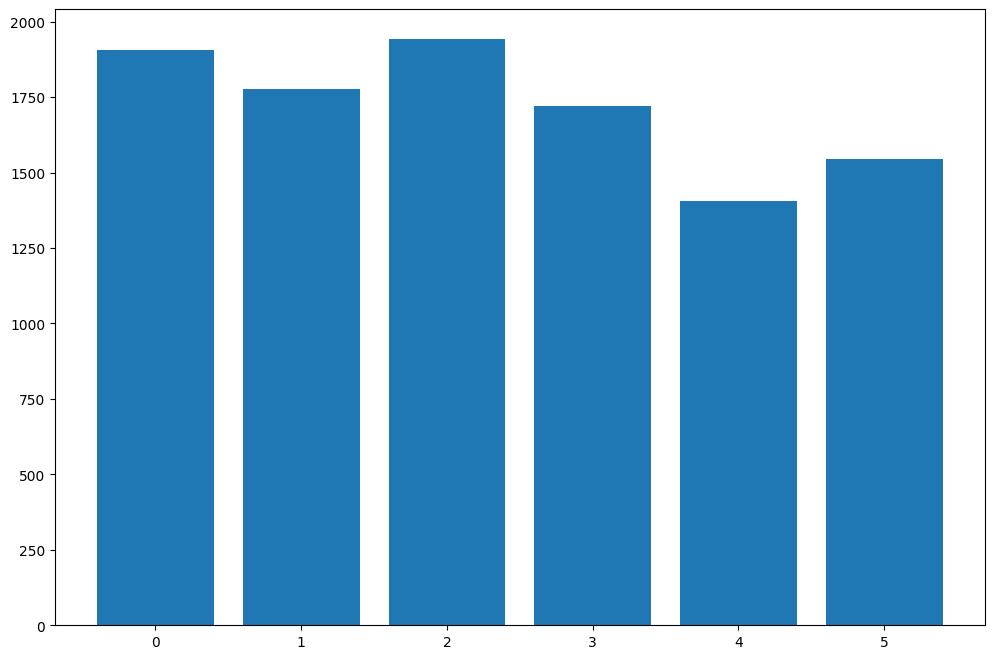

In [ ]:
#Accorpo i dati per una base preliminare
train['Data'] = 'Train'
test['Data'] = 'Test'
both = pd.concat( [train, test], axis=0 ).reset_index( drop=True )
activity = dict(enumerate(both['Activity'].unique()))
print(activity)
act, un_act = pd.factorize( both['Activity'] )
both['Activity'] = act

def basic_details(df):
  b = pd.DataFrame()
  b['Missing Value'] = df.isnull().sum()
  b['N unique value'] = df.nunique()
  b['dtype'] = df.dtypes
  return b
features = len(both.drop(['Data','subject','Activity'], axis = 1).columns)
print(features)
bd = basic_details(both)
activity = both['Activity']
label_counts = activity.value_counts()
print(label_counts)
plt.figure(figsize=(12, 8))
plt.bar(label_counts.index, label_counts)

In [ ]:
def PCA( train: pd.DataFrame, test: pd.DataFrame, retvar = 0.9):

  cov = train.cov().values
  mean = train.mean(axis=0)
  eig, vec = np.linalg.eig(cov) #Calcolo autovalori e autovettori
  eig, vec = np.real(eig), np.real(vec)
  order = np.argsort( -eig )
  evals = eig[order] #Ordino per grandezza del modulo

  #Conta il numero di componenti principali che superano il 99.9% di variabilità
  d = 1 + ( np.cumsum(evals) >= retvar * np.abs(evals.sum()) ).nonzero()[0][0]

  #Costruisco la matrice di cambiamento di base w di dimensione n_features X d
  w = vec[:, order[:d]]
  return [np.matmul( (train - mean).values, w ), np.matmul( (test - mean).values, w ),np.divide( np.cumsum(evals), evals.sum())]


class HARDataset( Dataset ):

  def __init__(self, data, transform = None, target_transform = None):
    if not(isinstance( data, pd.DataFrame )):
      self.data_tensor = pd.DataFrame(data)
    else:
      self.data_tensor = data
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.data_tensor)

  def __getitem__(self, idx):
    if not(isinstance( self.data_tensor['Activity'], int  )):
      act, self.un_act = pd.factorize( self.data_tensor['Activity'] )
      self.data_tensor['Activity'] = act
    data = torch.Tensor( self.data_tensor.drop(['Data','subject','Activity'], axis = 1).to_numpy() )
    label = torch.Tensor( self.data_tensor['Activity'].to_numpy() )
    return data[idx,:], label[idx]

#Normalizzo l'insieme totale di valori
norm_both = both.drop(['Data','subject','Activity'], axis = 1)

mean = both.drop(['Data','subject','Activity'], axis = 1).mean(axis=0)
var = both.drop(['Data','subject','Activity'], axis = 1).var(axis=0)

norm_both.add( -mean)
norm_both.div(var)

norm_both['Activity'] = act


#train_n = np.column_stack((train_n, np.expand_dims(train_lab, -1)))
#test_n = np.column_stack((test_n, np.expand_dims(test_lab, -1)))


#print(norm_both)



In [ ]:
loss_list_train = []
loss_list_test = []
acc_list_train = []
acc_list_test = []
n_batch = 64

#Define train and test loop
def train_loop(dataloader, model, loss_fn, optimizer):
  model.train()
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    batch_size, correct = 0, 0
    X, y = X.to(device), y.to(device).to(torch.long)
    one_hot_label = nn.functional.one_hot(y, num_classes=len(label_counts))
    #Compute prediction and loss
    pred = model(X) #torch.argmin(model(X) , -1).to(torch.long)
    loss = loss_fn(pred, y)
    train_label = torch.argmin(model(X) , -1)
    correct = (train_label==y).type(torch.int).sum().item()
    batch_size = X.size(0)
    correct /= batch_size
    acc_list_train.append(correct) #Take note of the single batch accuracy

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list_train.append(loss.item()) #
    if batch % 10 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"Funzione di loss: {loss:>7f} Errore train: \n Accuratezza: {(100*correct):>0.1f}%, [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    one_hot_label = torch.zeros(n_batch, len(label_counts))
    with torch.no_grad():
      for X, y in dataloader:
        batch_size, correct_batch =0, 0
        X, y = X.to(device), y.to(device).to(torch.long)
        one_hot_label[:,y] = 1
        #Compute prediction and loss
        pred = model(X) #torch.argmin(model(X) , -1).to(torch.long)
        loss = loss_fn(pred, y)
        loss_list_test.append(loss.item()) #Take note of the single batch loss
        test_loss +=loss_fn(pred, y).item()
        test_label = torch.argmin(model(X) , -1)
        correct += (test_label==y).type(torch.int).sum().item()
        correct_batch = (test_label==y).type(torch.int).sum().item()
        batch_size = X.size(0)
        correct_batch /= batch_size
        acc_list_test.append(correct_batch) #Take note of the batch accuracy


    test_loss /= num_batches
    correct /= num_batches
    print(f"Errore test: \n Accuratezza: {(100*correct):>0.1f}%, Media loss: {test_loss:>8f} \n")

#Define train and test loop
def dev_loop(dataloader, model, loss_fn, optimizer):
  model.train()
  size = len(dataloader.dataset)
  dev_loss, correct = 0.0, 0.0
  num_batches = len(dataloader)
  for batch, (X, y) in enumerate(dataloader):
    batch_size, batch_correct = 0, 0
    X, y = X.to(device), y.to(device).to(torch.long)
    one_hot_label = nn.functional.one_hot(y, num_classes=len(label_counts))
    #Compute prediction and loss
    pred = model(X) #torch.argmin(model(X) , -1).to(torch.long)
    loss = loss_fn(pred, y)
    dev_loss += loss
    train_label = torch.argmin(model(X) , -1)
    batch_correct = (train_label==y).type(torch.int).sum().item()
    correct += batch_correct
    batch_size = X.size(0)
    batch_correct /= batch_size
    acc_list_train.append(correct) #Take note of the single batch accuracy

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list_train.append(loss.item()) #

  dev_loss /= num_batches
  correct /= size
  print(f"Errore dev: \n Accuratezza: {(100*correct):>0.1f}%, Media loss: {dev_loss:>8f} \n")
  return correct

In [ ]:
n_features = features

class FixModel(nn.Module):

  def __init__(self, n_features: int, n_hidden: int=4096, n_layers:int = 8, dropout: float=0.5):
      super().__init__()
      self.model_type = "FFN"
      self.n_features = n_features
      self.n_hidden = n_hidden
      self.n_layers = n_layers

      self.lin_soft_stack_1 = [nn.Sequential(
          nn.Linear(int(n_hidden/2**(i)), int(n_hidden/2**(i+1))),
          nn.ReLU(),
          nn.Linear(int(n_hidden/2**(i+1)), int(n_hidden/2**(i+1))),
          nn.ReLU(),
          nn.Linear(int(n_hidden/2**(i+1)), int(n_hidden/2**(i+1))),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.BatchNorm1d(int(n_hidden/2**(i+1)))
      ) for i in range(self.n_layers)]
      self.lin_soft_stack_2 = self.lin_soft_stack_1
      self.lin_soft_stack_3 = self.lin_soft_stack_1

      self.lin_soft_stack_zero = nn.Sequential(
          nn.Linear(n_features, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.BatchNorm1d(n_hidden)
      )
      self.mid_lin_stack_1 = nn.Sequential(nn.Linear(int(n_hidden/2**(self.n_layers)), int(n_hidden/2**(self.n_layers)), nn.ReLU()))

      self.fin_lin_stack = nn.Sequential(nn.Linear(int(n_hidden/2**(self.n_layers)), len(un_act)), nn.Softmax(-1))

  def forward(self, src: Tensor) -> Tensor:

    first_input = self.lin_soft_stack_zero(src).to(device)
    first_input = first_input + nn.Sequential(nn.Linear(self.n_features, self.n_hidden),nn.ReLU()).to(device)(src)

    prec_input_first_stack = first_input
    prec_input_second_stack = first_input
    prec_input_third_stack = first_input
    for i in range(self.n_layers):
        input_first_stack = self.lin_soft_stack_1[i].to(device)(prec_input_first_stack)
        input_first_stack = input_first_stack + nn.Sequential(nn.Linear(int(self.n_hidden/2**(i)), int(self.n_hidden/2**(i+1))),nn.ReLU()).to(device)(prec_input_first_stack)
        prec_input_first_stack = input_first_stack

        input_second_stack = self.lin_soft_stack_2[i].to(device)(prec_input_second_stack)
        input_second_stack = input_second_stack + nn.Sequential(nn.Linear(int(self.n_hidden/2**(i)), int(self.n_hidden/2**(i+1))),nn.ReLU()).to(device)(prec_input_second_stack)
        prec_input_second_stack = input_second_stack

        input_third_stack = self.lin_soft_stack_3[i].to(device)(prec_input_third_stack)
        input_third_stack = input_third_stack + nn.Sequential(nn.Linear(int(self.n_hidden/2**(i)), int(self.n_hidden/2**(i+1))),nn.ReLU()).to(device)(prec_input_third_stack)
        prec_input_third_stack = input_third_stack

    mid_stack = nn.Softmax(-1)(input_first_stack*input_second_stack/int(self.n_hidden/2**(self.n_layers-1))**(1/2)).to(device)*input_third_stack
    mid_stack = self.mid_lin_stack_1(mid_stack)

    output = self.fin_lin_stack(mid_stack)
    return output

model_1 = FixModel(n_features).to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight).to(device)
        m.bias.data.fill_(0.01).to(device)

model_1.apply(init_weights)
model_1.to(device)

FixModel(
  (lin_soft_stack_zero): Sequential(
    (0): Linear(in_features=561, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mid_lin_stack_1): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (fin_lin_stack): Sequential(
    (0): Linear(in_features=16, out_features=6, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [ ]:
dev_frac = 0.01
test_frac = 0.01
train_frac = 1 - dev_frac - test_frac
batch_size = 64

#Mischio il dataframe (estraggo in maniera casuale tutte le righe del DataFrame)
both = both.sample(n=len(both))

#Creo i dataset per dev-train-set
train = both.sample(frac=train_frac)
test = both.sample(frac=test_frac)
dev = both.sample(frac=dev_frac)

train_dataset = HARDataset(train)
test_dataset = HARDataset(test)
dev_dataset = HARDataset(dev)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

#Definiamo la loss function, metodo di minimizzazione e iperparametri
learning_rate = [10**(-i) for i in range(1,5)]
momentum = [i/10 for i in range(10)]
lr_mom_grid = [(l,m, 0) for l in learning_rate for m in momentum]


loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate, momentum = momentum)

for i, (l, m, a) in enumerate(lr_mom_grid):
  print(f"Learning rate: {l}, Momentum: {m}")
  optimizer = torch.optim.SGD(model_1.parameters(), lr=l, momentum = m)
  epochs = 1
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      a += dev_loop(dev_dataloader, model_1, loss_fn, optimizer)

  a /= epochs
  lr_mom_grid[i] = (l,m, a)


Learning rate: 0.1, Momentum: 0.0
Epoch 1
-------------------------------
Errore dev: 
 Accuratezza: 19.4%, Media loss: 1.789362 

Learning rate: 0.1, Momentum: 0.1
Epoch 1
-------------------------------
Errore dev: 
 Accuratezza: 20.4%, Media loss: 1.793154 

Learning rate: 0.1, Momentum: 0.2
Epoch 1
-------------------------------
Errore dev: 
 Accuratezza: 11.7%, Media loss: 1.793347 

Learning rate: 0.1, Momentum: 0.3
Epoch 1
-------------------------------
Errore dev: 
 Accuratezza: 11.7%, Media loss: 1.794043 

Learning rate: 0.1, Momentum: 0.4
Epoch 1
-------------------------------
Errore dev: 
 Accuratezza: 17.5%, Media loss: 1.791581 

Learning rate: 0.1, Momentum: 0.5
Epoch 1
-------------------------------
Errore dev: 
 Accuratezza: 17.5%, Media loss: 1.790801 

Learning rate: 0.1, Momentum: 0.6
Epoch 1
-------------------------------
Errore dev: 
 Accuratezza: 13.6%, Media loss: 1.791884 

Learning rate: 0.1, Momentum: 0.7
Epoch 1
-------------------------------
Errore de

KeyboardInterrupt: 

As we can see the development accuracy doesn't reach 20% despite the model complexity. The classsification using a multilayer perceptron is a failure